# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

# TO-DO
- Write just one model
- Better frames for datasets
- Regression

In [1]:
from sklearn.svm import SVC
from sklearn.svm import SVR, LinearSVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import tqdm
import config
import math
import matplotlib.pyplot as plt
import scikitplot as skplt
from utils import filter_and_split_dataset



In [2]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()

metrics = []


FileNotFoundError: [Errno 2] No such file or directory: '/media/andrea/20D2-63FB/Training/'

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import config
import dlib
import time


sample = d.dataset[40][random.randint(0, len(d.dataset[40]))]
frame = d.read_image(sample[0])
face = d.crop_face(frame,d.read_2d_skeleton(sample[3]))[0]
orig = face.copy()

def extract_landmark_features(img):
    # Import the necessary libraries
    
    # Load the pre-trained facial landmark detection model
    predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

    # Load the input image and convert it to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # Use the predictor to detect the facial landmarks in the grayscale image
    dets = dlib.get_frontal_face_detector()
    

    faces = dets(gray)
    if len(faces) <= 0:
        return None
    points_x = []   
    points_y = []    

    # Loop through the detected faces and extract the landmark features
    shape_np = np.zeros((68, 2), dtype="int")
    for face in faces:
        shape = predictor(gray, face)
        #use the np array?
        for i in range(0, 68):
                shape_np[i] = (shape.part(i).x, shape.part(i).y)
                cv2.circle(img, (shape.part(i).x, shape.part(i).y), 1, (0, 255, 0), -1)
    
    return shape_np

def extract_hog_features(img):
    # Import the necessary libraries
    from skimage.feature import hog
    from skimage import data, exposure

    # Load the input image and convert it to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # Extract the hog features from the grayscale image
    fd, hog_image = hog(gray, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)

    # Rescale the output image for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_image_rescaled

def extract_lbp_features(img):
    # Import the necessary libraries
    from skimage.feature import local_binary_pattern

    # Load the input image and convert it to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    # Apply local binary pattern to the grayscale image
    radius = 1
    no_points = 30 * radius
    lbp = local_binary_pattern(gray, no_points, radius, method='uniform')

    return lbp



ld = extract_landmark_features(face)
hog = extract_hog_features(face)
lbp = extract_lbp_features(face)
# haar = extract_haar_features(face)


while(ld is None):
    sample = d.dataset[40][random.randint(0, len(d.dataset[40]))]
    frame = d.read_image(sample[0])
    face = d.crop_face(frame,d.read_2d_skeleton(sample[3]))[0]
    orig = face.copy()
    ld = extract_landmark_features(face)
    hog = extract_hog_features(face)
    lbp = extract_lbp_features(face)
fig, ax = plt.subplots(1, 4,figsize=(15,15))
ax[0].imshow(orig)
ax[1].imshow(face)
ax[2].imshow(hog)
ax[3].imshow(lbp)
#plot the lbp
plt.show()

The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [ ]:
def test_model(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    global metrics
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)


    print("-" * 10)
    print("|", name, "|")
    # Test
    print("-" * 10)
    skel_pred = model_skel.predict(X_skel_test)
    print(classification_report(y_test, skel_pred))
    print("-" * 10)
    clothes_pred = model_clothes.predict(X_clothes_test)
    print(classification_report(y_test, clothes_pred))
    print("-" * 10)
    face_pred = model_face.predict(X_face_test)
    print(classification_report(y_face_test, face_pred))

    skel_pred_roc = model_skel.predict_proba(X_skel_test)
    clothes_pred_roc = model_clothes.predict_proba(X_clothes_test)
    face_pred_roc = model_face.predict_proba(X_face_test)

    metrics.append([name.split("_")[-1].split(".")[-1], y_test, y_face_test, skel_pred, clothes_pred, face_pred, skel_pred_roc, clothes_pred_roc, face_pred_roc])


In [ ]:
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)



In [ ]:

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers_skel = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_clothes = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=2, splitter='best'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100, random_state = 4),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_face = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=9, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

fig, ((ax_roc_skel, ax_roc_clothes, ax_roc_face), (ax_det_skel, ax_det_clothes, ax_det_face)) = plt.subplots(2, 3, figsize =(20, 10))
# fig, (ax_roc_skel, ax_roc_clothes, ax_roc_face, ax_det_skel, ax_det_clothes, ax_det_face) = plt.subplots(1, 6, figsize=(50,5))

for name, model in classifiers_skel.items():
    model.fit(X_skel, y_train)
    RocCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_roc_skel, name=name)
    DetCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_det_skel, name=name)

for name, model in classifiers_clothes.items():
    model.fit(X_clothes, y_train)
    RocCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_roc_clothes, name=name)
    DetCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_det_clothes, name=name)

for name, model in classifiers_face.items():
    model.fit(X_face, y_face)
    RocCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_roc_face, name=name)
    DetCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_det_face, name=name)


ax_roc_skel.set_title("Receiver Operating Characteristic (ROC) curves - Skeleton")
ax_det_skel.set_title("Detection Error Tradeoff (DET) curves - Skeleton")
ax_roc_clothes.set_title("Receiver Operating Characteristic (ROC) curves - Clothes")
ax_det_clothes.set_title("Detection Error Tradeoff (DET) curves - Clothes")
ax_roc_face.set_title("Receiver Operating Characteristic (ROC) curves - Face")
ax_det_face.set_title("Detection Error Tradeoff (DET) curves - Face")


ax_roc_skel.grid(linestyle="--")
ax_det_skel.grid(linestyle="--")
ax_roc_clothes.grid(linestyle="--")
ax_det_clothes.grid(linestyle="--")
ax_roc_face.grid(linestyle="--")
ax_det_face.grid(linestyle="--")


plt.legend()
plt.savefig("ROC_DET_curves.png")

## Model Tuning

### Fit and Evaluate Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
# from math import round

class_names = ['Different', 'Same']

def fit_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train.ravel())
        print(name, 'trained.')
    return

def evaluate_models(models,model_name,X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred,zero_division=0))
        cv_accuracy = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='accuracy')
        cv_precision = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='precision')
        cv_f1_macro = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='f1_macro')
        print(cross_val_score(model, X_test, y_test, scoring='accuracy'))
        print("Accuracy: %0.4f (+/- %0.4f)" % (cv_accuracy.mean(), cv_accuracy.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='precision'))
        print("Precision: %0.4f (+/- %0.4f)" % (cv_precision.mean(), cv_precision.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='f1_macro'))
        print("f1-score: %0.4f (+/- %0.4f)" % (cv_f1_macro.mean(), cv_f1_macro.std() * 2))
        if name.count("accuracy") > 0 or name.count("precision") > 0:
            cm = confusion_matrix(y_test, y_pred)
            cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            disp = ConfusionMatrixDisplay(confusion_matrix=cmn, display_labels=class_names)
            disp.plot(cmap=plt.cm.Purples)
            disp.ax_.set_title(name + ' (' + model_name + ')') 
        print('------------------------------------'*3)
        
    return  

### Model Tuning

In [ ]:

def tune_model(model, param_grid, scoring, x_train, y_train, grid_jobs):
    print('tuning...')
    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, verbose=1, n_jobs=grid_jobs)
    clf.fit(x_train, y_train.ravel())
    print('done')
    print()
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    best_params = clf.best_params_.copy()
    return best_params

### Models

In [ ]:

SVM_param_grid = {
    'C': [1],
    'kernel': ['linear'],
    'degree': [3],
    'gamma': ['auto'],
    'random_state': [42],
    'tol': [1e-3]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}


Gauss_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

KNN_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}

Regres_param_grid = {
    'solver': ['liblinear'],
    'max_iter': [10000]
}

models = {
    # "KNN": (KNeighborsClassifier, KNN_param_grid),
    # "DT": (DecisionTreeClassifier, DT_param_grid),
    # "RF": (RandomForestClassifier, RF_param_grid),
    # "GNB": (GaussianNB, Gauss_param_grid),
    "SVM": (SVC, SVM_param_grid),
    # "LogReg": (LogisticRegression, Regres_param_grid),
}

### Tuning and Evaluation

In [ ]:

for model in models:
    print(model)
    current_model = models[model]
    best_accuracy_params_skel = tune_model(current_model[0](), current_model[1], 'accuracy', X_skel, y_train, -1)
    best_precision_params_skel = tune_model(current_model[0](), current_model[1], 'precision', X_skel, y_train, -1)
    best_f1macro_params_skel = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_skel, y_train, -1)
    best_accuracy_params_clothes = tune_model(current_model[0](), current_model[1], 'accuracy', X_clothes, y_train, -1)
    best_precision_params_clothes = tune_model(current_model[0](), current_model[1], 'precision', X_clothes, y_train, -1)
    best_f1macro_params_clothes = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_clothes, y_train, -1)
    best_accuracy_params_face = tune_model(current_model[0](), current_model[1], 'accuracy', X_face, y_face, -1)
    best_precision_params_face = tune_model(current_model[0](), current_model[1], 'precision', X_face, y_face, -1)
    best_f1macro_params_face = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_face, y_face, -1)
    tuned_models_skel = {
        'Skeleton accuracy': current_model[0](**best_accuracy_params_skel),
        'Skeleton precision': current_model[0](**best_precision_params_skel),
        'Skeleton f1_macro': current_model[0](**best_f1macro_params_skel)
    }

    tuned_models_clothes = {
        'Clothes accuracy': current_model[0](**best_accuracy_params_clothes),
        'Clothes precision': current_model[0](**best_precision_params_clothes),
        'Clothes f1_macro': current_model[0](**best_f1macro_params_clothes)
    }

    tuned_models_face = {
        'Face accuracy': current_model[0](**best_accuracy_params_face),
        'Face precision': current_model[0](**best_precision_params_face),
        'Face f1_macro': current_model[0](**best_f1macro_params_face)
    }
        
    # fit_models(tuned_models_skel, X_skel, y_train)
    # fit_models(tuned_models_clothes, X_clothes, y_train)
    fit_models(tuned_models_face, X_face, y_face)
    print("-"*50)
    print("Skeleton")
    # evaluate_models(tuned_models_skel,model, X_skel_test, y_test)
    print("-"*50)
    print("Clothes")
    print("-"*50)
    # evaluate_models(tuned_models_clothes,model, X_clothes_test, y_test)
    print("-"*50)
    print("Face")
    print("-"*50)
    evaluate_models(tuned_models_face,model, X_face_test, y_face_test)


### Results
| Model | Skeleton | Clothes | Face | 
| :--- | :---: | :---: | :---: | 
| DT | 0.91 | 0.93  | 0.81 |
| RF | 0.93 | 0.94  | 0.85 |
| SVC | 0.91 | 0.93  | 0.81 |
| GNB | 0.89 | 0.79  | 0.81 |
| KNN | 0.94 | 0.94  | 0.84 |

In [ ]:
# Train the models on the big dataset

X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

model_skel = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance')  #  RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
model_clothes = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=5, p=1, weights='distance')  # RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = 42)
model_face = SVC(C = 1, kernel = "poly", degree = 3, gamma = "auto", probability = True, random_state = 2)


model_skel.fit(X_skel, y_train)
model_clothes.fit(X_clothes, y_train)
# model_face.fit(X_face, y_face)

# Sample dataset live

X, y, images = d.sample_dataset(video=0, return_images=True, seed=10)
X_train, _, y_train, __, images_train, ___ = train_test_split(X, y, images, stratify=y)
print(y_train)

print("-" * 10)
print("skel")
skel_pred = model_skel.predict(X_train[:, : 9])
print(skel_pred)
print(classification_report(y_train, skel_pred))
print("-" * 10)
print("clothes")
clothes_pred = model_clothes.predict(X_train[:, 9 : 9 + config.NUM_POINTS_LBP])
print(clothes_pred)
print(classification_report(y_train, clothes_pred))
print("-" * 10)


# print("face")
# X_face = []
# y_face = []

# for i in range(len(X_train)):
#     if not math.isnan(X_train[i][0]):
#         X_face.append(X_train[i])
#         y_face.append(y_train[i])
        
# face_pred = model_face.predict(X_face)
# print(classification_report(y_face, face_pred))



target = np.where(y_train == 1)
target_img = images_train[target[0][0]]

fig, ax = plt.subplots(len(y_train) // 5 + 1, 5)
fig.set_size_inches(18.5, 10.5)

for i in range(len(y_train)):
    t, el = y_train[i], images_train[i]
    ax[i // 5, i % 5].imshow(el)
plt.show()
 

for idx in range(len(y_train)):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax[0].imshow(images_train[idx])
    ax[0].set_title(f"True label: {y_train[idx]}, predict: {bool(skel_pred[idx] or clothes_pred[idx])}")
    ax[1].imshow(target_img)
    ax[1].set_title("Target")#"skel label: " + str(bool(res[1][0])), "clothes label: " + str(bool(res[1][1])), "face label: " + str(bool(res[1][2])))
    print(skel_pred[idx], clothes_pred[idx])
    plt.show()

## Regression

We also thought that it was possible to learn a "latent space" that ensambles that person's features. The idea is that a regressor can learn how to optimize the outpot of a linear combination so that features from the person that we want to re-identify will output a low value (0) while the other people will output an higher value (1).

Given that, we tested some regressors in order to learn the features of a person.

In [6]:
# X_logistic, y_logistc, _ = d.sample_dataset(video=0, return_images=False)
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
y -= 1
y *= -1
X_skel, X_clothes, X_face, trhs_skel, trhs_clothes, trhs_faces, y_train, y_trhs, y_face, y_trhs_face = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
y_2 -= 1
y_2 *= -1
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)

trsh = 0

def test_regression(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    
    # fit the model on the training set
    
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)

    # Test
    print("-" * 10)
    print("|", name, "|")
    print("-" * 10)
    print("| skel |")
    skel_pred = model_skel.predict(X_skel_test)

    # print(classification_report(y_test, skel_pred, zero_division=0))
    # print(mean_absolute_error(y_test_logistic, skel_pred))
    # print(mean_squared_error(y_test_logistic, skel_pred))

    print("| clothes |")
    clotehs_pred = model_clothes.predict(X_clothes_test)

    # print(classification_report(y_test, clotehs_pred, zero_division=0))
    # print(mean_absolute_error(y_test, clotehs_pred))
    # print(mean_squared_error(y_test, clotehs_pred))

    print("| face |")
    face_pred = model_face.predict(X_face_test)

    # print(classification_report(y_face_test, face_pred, zero_division=0))
    # print(mean_absolute_error(y_face_test, face_pred))
    # print(mean_squared_error(y_face_test, face_pred))
    
    
    global trsh
    
    plt.plot(y_test, clotehs_pred, 'o')
    plt.plot([0, 1], [model_skel.named_steps["SVRLogistic"].trhs] * 2, 'r-')
    plt.show()

    plt.plot(y_test, skel_pred, 'o')
    plt.plot([0, 1], [model_skel.named_steps["SVRLogistic"].trhs] * 2, 'r-')
    plt.show()

    plt.plot(y_face_test, face_pred, 'o')
    plt.plot([0, 1], [model_skel.named_steps["SVRLogistic"].trhs] * 2, 'r-')
    plt.show()

In [13]:
class SVRLogistic(RegressorMixin):
    def __init__(self, trhs_tests, trhs_labels, svr_parameters = dict(), log_reg_parameters = dict()):
        self.model = SVR(kernel='rbf', C=1, gamma=0.1, epsilon=.1)
        for k, v in svr_parameters.items():
            setattr(self.model, k, v)
        self.log_reg = LogisticRegression()
        for k, v in log_reg_parameters.items():
            setattr(self.log_reg, k, v)
        self.trhs = 0
        self.trhs_tests = trhs_tests
        self.trhs_labels = trhs_labels
        
    def fit(self, X, y):
        self.model.fit(X, y)
        # Set a treshold
        pf = PolynomialFeatures()

        predicted = self.predict(pf.fit_transform(self.trhs_tests))
        # reorder based on prediction
        rerank = [_ for _ in zip(predicted, self.trhs_labels)]
        rerank.sort(key=lambda x: x[0])
        rerank = np.asarray(rerank)
        # get the first index where the prediction is correct
        first_correct = np.where(rerank[:, 1] > 0)[0][0]
        self.trhs = rerank[first_correct, 0]
        print(self.trhs)
        # self.log_reg.fit(self.model.predict(X).reshape(-1, 1), y)
        return self

    def predict(self, X):
        # return self.log_reg.predict(self.model.predict(X).reshape(-1, 1))
        return self.model.predict(X)

0.8870448418118834
0.8727018016261425
0.8752130367773965
----------
| Pipeline |
----------
| skel |
| clothes |
| face |


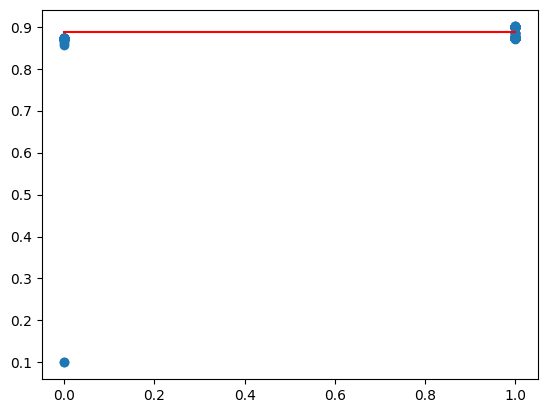

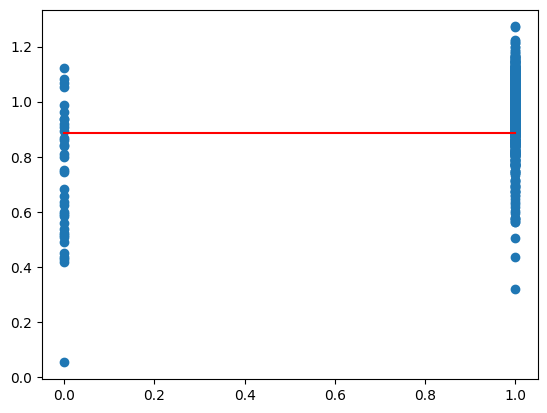

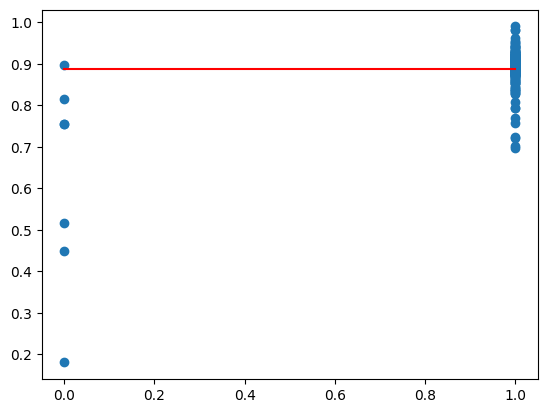

In [14]:
m1 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("SVRLogistic", SVRLogistic(trhs_skel, y_trhs))])
m2 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("SVRLogistic", SVRLogistic(trhs_clothes, y_trhs))])
m3 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("SVRLogistic", SVRLogistic(trhs_faces, y_trhs_face))])
test_regression("Pipeline", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)